# PROYECTO GRUPAL TID
---

**Instalamos** las dependencias necesarias para el proyecto.

In [ ]:
%pip install --upgrade pip
%pip install kagglehub
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install outliers
%pip install plotly
%pip install nbformat
%pip install sklearn
%pip install --upgrade mpl_toolkits
%pip install tensorflow
%matplotlib inline

# 1. Tratamiento de datos
En primer lugar, vamos a importar las librerías necesarias para el tratamiento de datos.

In [2]:
import pandas as pd
import re

Una vez importadas, vamos a cargar el dataset de entrenamiento y el de testeo. Para ello, utilizamos la función `pd.read_csv()` de la librería `pandas`. Esta función nos permite leer archivos CSV y convertirlos en un DataFrame de pandas.

In [3]:
database = pd.read_csv('database/laptop_data.csv')
database.head()

,ID,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


Procedemos una vez tenemos cargada la base de datos, a tratar los datos para poder utilizarlos en el modelo. Para ello, vamos a realizar las siguientes tareas:
- Corregir la moneda de los precios, pasando de libras egipcias a euros.
- Estandarizar las resoluciones de las pantallas, a numero de píxeles.
- Convertir las variables categóricas en variables numéricas, como puede ser el caso de la RAM, el almacenamiento o el peso.
- Para otro tipo de variables categóricas, como puede ser el caso de la marca, el sistema operativo o el tipo de pantalla, lo que haremos será extraer en nuevas columnas toda la información que nos pueda aportar riqueza al modelo.
- Se eliminarán las columnas que no aporten valor al modelo, como puede ser el caso del ID del producto.

In [4]:
# Convierte el precio de EGP a EUR
def ConvertPrice(originalCoin):
  EGP_TO_EUR = 0.019
  newCoin = originalCoin * EGP_TO_EUR
  return round(newCoin, 2)

# Calcula la cantidad de píxeles a partir de la resolución de pantalla
def CalculatePixels(cadena):
  # Expresión regular para encontrar una resolución en formato WIDTHxHEIGHT
  match = re.search(r"(\d{3,4})x(\d{3,4})", cadena)
  
  if match:
    width, height = map(int, match.groups())
    return width * height
  
  # Retorna -1 si no se encuentra una resolución válida
  return -1  

# Limpia la cadena de RAM y devuelve solo el número
def CleanRam(ram):
  return int(ram.replace('GB', ''))

# Limpia la cadena de CPU y devuelve un diccionario con la marca, modelo y frecuencia
def CleanCPU(cadena):
  # Expresión regular para capturar la marca, modelo y frecuencia de la CPU
  match = re.match(r"(Intel|AMD)\s+(.+)\s+(\d+(\.\d+)?)GHz", cadena)
  if match:
    # Creamos nuevas columnas con las variables separadas
    return {
      "CpuBrand": match.group(1),
      "CpuModel": match.group(2).strip(),
      "CpuFrequency": float(match.group(3))
    }
  return None

# Limpia la cadena de memoria y devuelve el total en GB
def CleanMemory(cadena):
  # Expresión regular para capturar valores de almacenamiento en GB o TB
  pattern = r"(\d+(?:\.\d+)?)(TB|GB)"
  
  total_storage = 0
  matches = re.findall(pattern, cadena)

  for value, unit in matches:
    value = float(value)
    # Convertir TB a GB
    if unit == "TB":  
      value *= 1024
    total_storage += value

  # Devolver como entero en GB
  return int(total_storage) 

# Limpia la cadena de peso y devuelve el valor numérico
def ConvertWeight(cadena):
  return float(cadena.replace('kg', ''))

# Limpia la cadena de sistema operativo y devuelve el nombre limpio
def CleanOs(cadena):
  # Convertir a minúsculas para comparación sin distinción de mayúsculas
  cadena = cadena.lower()  
  if re.search(r"\b(mac\s*os|macbook|macintosh|os\s*x)\b", cadena):
    return "Mac"
  elif re.search(r"\b(windows|win\s*\d+|win\s*xp|win\s*7|win\s*8|win\s*10|win\s*11)\b", cadena):
    return "Windows"
  else:
    return "Null"

# Limpia la cadena de GPU y devuelve un diccionario con la marca y modelo
def CleanGPU(cadena):
  # Expresión regular para capturar la marca y el modelo de la GPU  
  match = re.match(r"(Intel|AMD|Nvidia)\s+(.+)", cadena, re.IGNORECASE)
  if match:
    brand = match.group(1)
    model = match.group(2).strip()
    return {
      "GpuBrand": brand, 
      "GpuModel": model
    }
  # Si no hay coincidencia, devuelve None
  return None  
  
def transformCSV(database):
  for index, row in database.iterrows():
    database.at[index, 'Price'] = ConvertPrice(row['Price'])
    database.at[index, 'ScreenResolution'] = CalculatePixels(row['ScreenResolution'])
    database.at[index, 'Ram'] = CleanRam(row['Ram'])
    cpu_info = CleanCPU(row['Cpu'])
    if cpu_info:
      database.at[index, 'CpuBrand'] = cpu_info['CpuBrand']
      database.at[index, 'CpuModel'] = cpu_info['CpuModel']
      database.at[index, 'CpuFrequency'] = cpu_info['CpuFrequency']
    database.at[index, 'Memory'] = CleanMemory(row['Memory'])
    database.at[index, 'Weight'] = ConvertWeight(row['Weight'])
    database.at[index, 'OpSys'] = CleanOs(row['OpSys'])
    gpu_info = CleanGPU(row['Gpu'])
    if gpu_info:
      database.at[index, 'GpuBrand'] = gpu_info['GpuBrand']
      database.at[index, 'GpuModel'] = gpu_info['GpuModel']
  database.drop(columns=['Cpu'], inplace=True)
  database.drop(columns=['Gpu'], inplace=True)
  database.drop(columns=['ID'], inplace=True)
    
  return database

transformCSV(database)
database.head()

,Company,TypeName,Inches,ScreenResolution,Ram,Memory,OpSys,Weight,Price,CpuBrand,CpuModel,CpuFrequency,GpuBrand,GpuModel
0,Apple,Ultrabook,13.3,4096000,8,128,Mac,1.37,1356.19,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,1296000,8,128,Mac,1.34,910.01,Intel,Core i5,1.8,Intel,HD Graphics 6000
2,HP,Notebook,15.6,2073600,8,256,Null,1.86,582.08,Intel,Core i5 7200U,2.5,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,5184000,16,512,Mac,1.83,2568.71,Intel,Core i7,2.7,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,4096000,8,256,Mac,1.37,1825.82,Intel,Core i5,3.1,Intel,Iris Plus Graphics 650


A continuación, mostramos de qué tipo es cada variable y qué tipo de tratamiento se le va a dar. Para ello, utilizamos la función `database.info()` de pandas, que nos permite ver el tipo de datos de cada columna y si hay valores nulos o no.

In [5]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Ram               1303 non-null   object 
 5   Memory            1303 non-null   object 
 6   OpSys             1303 non-null   object 
 7   Weight            1303 non-null   object 
 8   Price             1303 non-null   float64
 9   CpuBrand          1302 non-null   object 
 10  CpuModel          1302 non-null   object 
 11  CpuFrequency      1302 non-null   float64
 12  GpuBrand          1302 non-null   object 
 13  GpuModel          1302 non-null   object 
dtypes: float64(3), object(11)
memory usage: 142.6+ KB


Observamos que la mayoría de las variables son objetos, lo que significa que son variables categóricas. Sin embargo, hay algunas variables que son numéricas, como el precio o la resolución de la pantalla. Estas variables se pueden utilizar directamente en el modelo, pero las variables categóricas deben ser convertidas en variables numéricas.

---
## 2. Clasificación
En esta sección, vamos a realizar la clasificación de los datos utilizando el algoritmo KNN (K-Nearest Neighbors). Este enfoque nos permitirá categorizar los precios de los laptops en diferentes rangos basándonos en sus características técnicas.

### Carga de librerías

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

### Correlación entre variables

Para realizar la clasificación de los datos, primero vamos a visualizar la correlación entre las variables. No sin antes eliminar todas aquellas variables categóricas que no aporten valor al modelo. Para ello, utilizamos la función `database.corr()` de pandas, que nos permite ver la correlación entre las variables. A continuación, mostramos un gráfico de calor con la correlación entre las variables.

<Axes: >

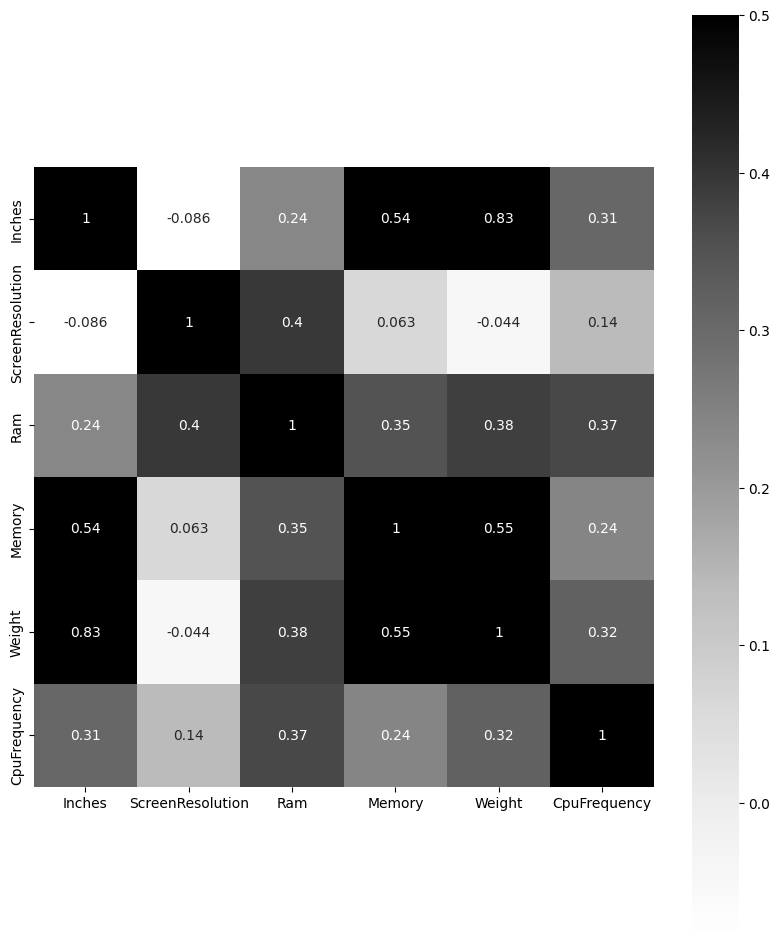

In [7]:
qualitative_columns = ['Company', 'TypeName', 'CpuBrand', 'CpuModel', 'GpuBrand', 'GpuModel', 'OpSys', 'Price']
    
# Mostramos la matriz de correlación para ver la relación que guardan las variables entre sí
matrix = database.drop(columns=qualitative_columns).corr()
f, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(matrix, vmax=.5, square=True, cmap="Greys", annot=True)

Podemos observar que hay variables que están muy correlacionadas entre sí, como el peso y las pulgadas, o la memoria. Esto significa que estas variables pueden estar relacionadas entre sí y pueden influir en el modelo. Por lo tanto, es importante tener en cuenta estas variables al construir el modelo.

### Detección de outliers
Sin embargo, veamos si esta correlación no está motivada por factores como los 'outliers' o valores atípicos en la base de datos, que pueden influir en la correlación entre las variables. Para ello, vamos a utilizar un gráfico de cajas (boxplot). 

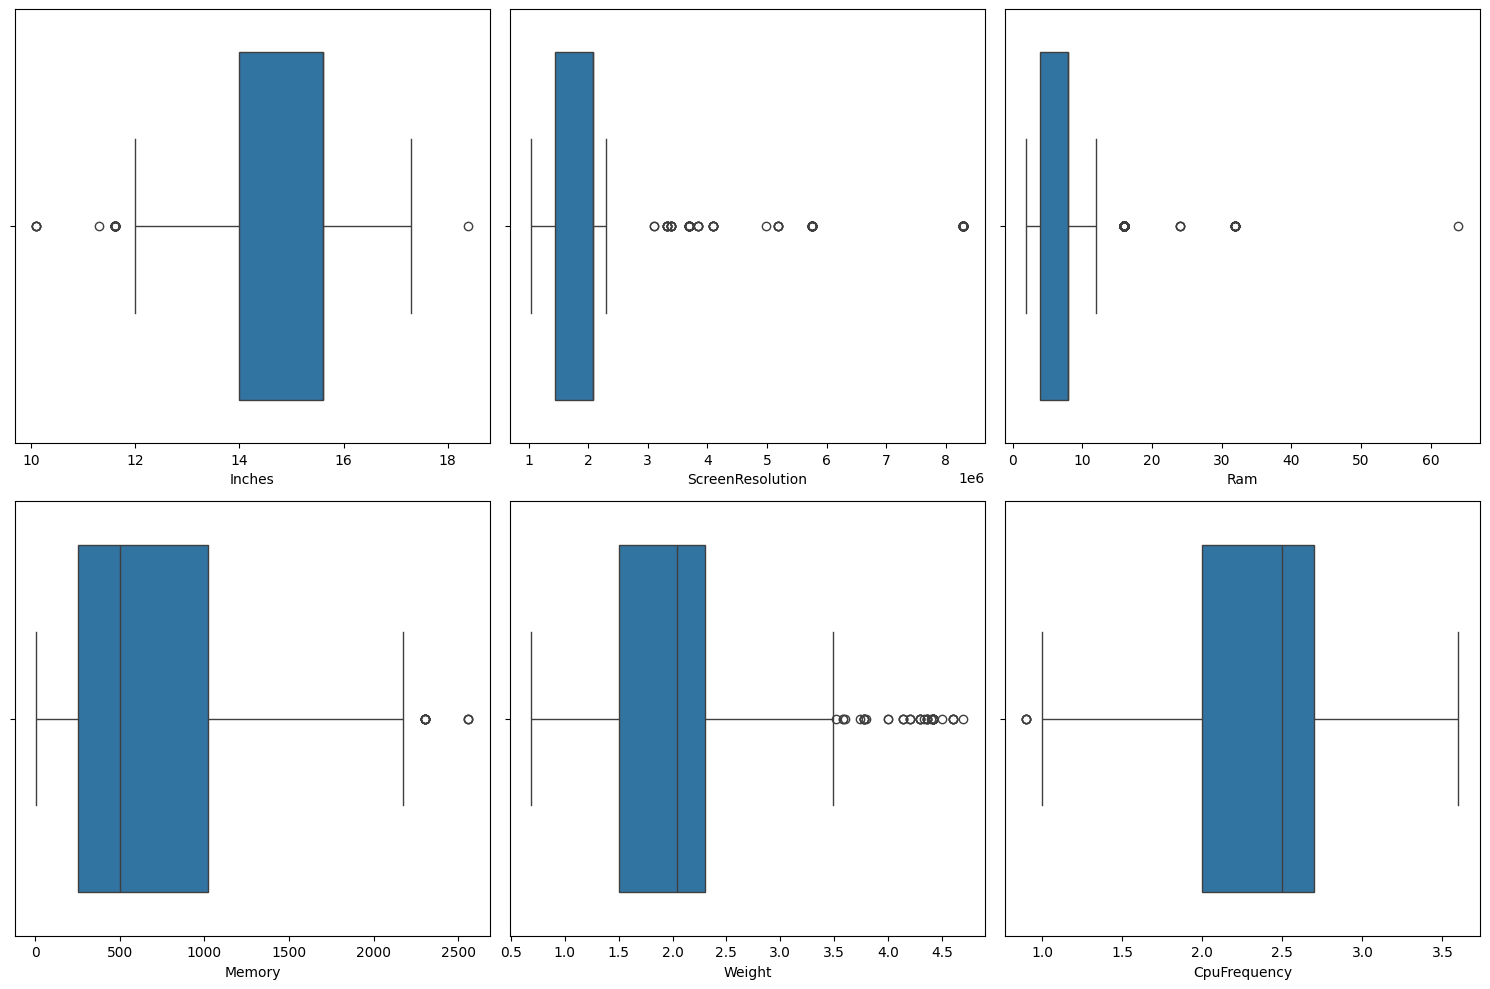

In [8]:
# Determinamos el número de columnas y filas para el mosaico
num_cols = 3
num_rows = (len(database.columns) - len(qualitative_columns) + num_cols - 1) // num_cols

# Creamos la figura y los ejes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Filtramos las columnas numéricas
numeric_columns = [col for col in database.columns if col not in qualitative_columns]

# Iteramos sobre las columnas numéricas y generamos los boxplots
for i, col in enumerate(numeric_columns):
  sns.boxplot(data=database, x=col, ax=axes[i])

# Ocultamos los ejes sobrantes si hay más subplots que columnas numéricas
for j in range(len(numeric_columns), len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()

Vemos que hay algunos valores atípicos en la base de datos, como el precio o la resolución de la pantalla. Estos valores atípicos pueden influir en el modelo y pueden hacer que el modelo no sea preciso. Por lo tanto, es importante tener en cuenta estos valores atípicos al construir el modelo, sin embargo, no vamos a eliminarlos de la base de datos, ya que pueden aportar información valiosa al modelo.

In [9]:
qualitative_columns.remove('Price')
quantitative_database = database.drop(qualitative_columns, axis=1)
quantitative_database.head()

,Inches,ScreenResolution,Ram,Memory,Weight,Price,CpuFrequency
0,13.3,4096000,8,128,1.37,1356.19,2.3
1,13.3,1296000,8,128,1.34,910.01,1.8
2,15.6,2073600,8,256,1.86,582.08,2.5
3,15.4,5184000,16,512,1.83,2568.71,2.7
4,13.3,4096000,8,256,1.37,1825.82,3.1


### Separación de datos

Lo que haremos a continuación será dividir la base de datos en dos partes: una parte de entrenamiento y otra parte de testeo. Para ello, utilizamos la función `train_test_split()` de la librería `sklearn.model_selection`. Esta función nos permite dividir la base de datos en dos partes: una parte de entrenamiento y otra parte de testeo. La parte de entrenamiento se utiliza para entrenar el modelo y la parte de testeo se utiliza para evaluar el modelo.

In [10]:
x = database.drop('Price', axis=1).apply(pd.to_numeric, errors='coerce')
y = database['Price'].values

x.fillna(x.mean(), inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

Una vez que hemos separado los datos, vamos a definir 5 grupos de clasificación, que serán los siguientes:
- Very low
- Low
- Medium
- High
- Very high

Para ello, utilizamos la función `pd.cut()` de pandas, que nos permite dividir los datos en grupos. Esta función nos permite definir los límites de cada grupo y asignar un nombre a cada grupo.

In [11]:
y_train_classes = pd.cut(y_train, bins = 5, labels=["very low", "low", "medium", "high", "very high"])
y_test_classes = pd.cut(y_test, bins = 5, labels=["very low", "low", "medium", "high", "very high"])

# Comprobamos como hace la división de los datos en clases
print(y_train_classes.value_counts())

very low     701
low          239
medium        33
high           3
very high      1
Name: count, dtype: int64


### Modelo KNN (K-Nearest Neighbors)

Una vez divididos los rangos, vamos a utilizar el método KNN (K-Nearest Neighbors) para clasificar los datos. Este método se basa en la idea de que los datos similares están cerca unos de otros en el espacio de características. Por lo tanto, si un nuevo dato se encuentra cerca de un grupo de datos, se puede clasificar en ese grupo.

Para ello, utilizamos la función `KNeighborsClassifier()` de la librería `sklearn.neighbors`. Esta función nos permite crear un clasificador KNN y entrenarlo con los datos de entrenamiento. Una vez entrenado el modelo, podemos utilizarlo para predecir la clase de los datos de testeo.

Finalmente, mostraremos la precisión de este modelo, tanto en el conjunto de entrenamiento como en el de testeo.

In [12]:
n_neighbors = 7

# Imputamos los valores faltantes en el conjunto de entrenamiento y prueba con la media
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train_imputed, y_train_classes)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train_imputed, y_train_classes)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test_imputed, y_test_classes)))

Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.79


/home/raul/Escritorio/TID-GRUPAL/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Company' 'TypeName' 'OpSys' 'CpuBrand' 'CpuModel' 'GpuBrand' 'GpuModel']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/raul/Escritorio/TID-GRUPAL/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Company' 'TypeName' 'OpSys' 'CpuBrand' 'CpuModel' 'GpuBrand' 'GpuModel']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Vemos que no tiene una mala precisión, y el modelo ha ajustado las clases de forma más homogenea.

In [13]:
print(y_test_classes.value_counts())

very low     200
low          100
medium        23
high           1
very high      2
Name: count, dtype: int64


Sin embargo, comprobemos la veracidad del modelo, utilizando la matriz de confusión. Para ello, utilizamos la función `confusion_matrix()` de la librería `sklearn.metrics`. Esta función nos permite crear una matriz de confusión y visualizarla con un gráfico de calor. 

A continuación, mostramos un gráfico de calor con la matriz de confusión.

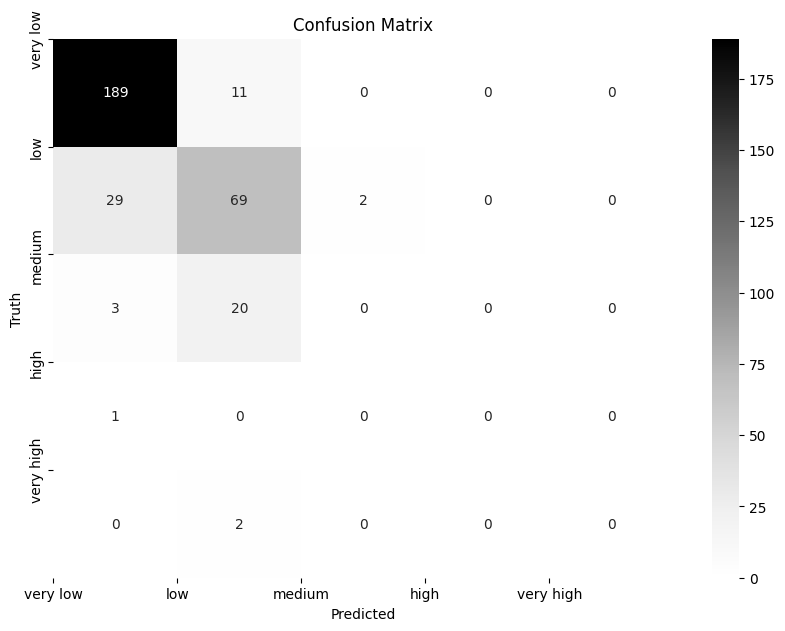

In [14]:
pred = knn.predict(x_test_imputed)
cm = confusion_matrix(y_test_classes, pred, labels=["very low", "low", "medium", "high", "very high"])

# Visualizamos la matriz de confusión generada
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
plt.xlabel('Predicted')
plt.xticks(ticks=range(5), labels=["very low", "low", "medium", "high", "very high"])
plt.ylabel('Truth')
plt.yticks(ticks=range(5), labels=["very low", "low", "medium", "high", "very high"])
plt.title('Confusion Matrix')

plt.show()

Vemos que el modelo lo que hace es clasificar siempre en la clase 'Very low', lo que significa que el modelo no es capaz de clasificar los datos correctamente. Esto puede deberse a que el modelo no tiene suficientes datos para entrenarse o a que el modelo no es lo suficientemente complejo para clasificar los datos. Por lo tanto, es importante tener en cuenta estos factores al construir el modelo. 

Es por ello que probaremos usando la regresión, que es un modelo más complejo y puede clasificar los datos de forma más precisa.

---
## 3. Regresión
Para el análisis de regresión, utilizaremos modelos que nos permitan predecir el precio de los laptops basándonos en sus características técnicas. Este enfoque nos permitirá entender qué variables tienen mayor influencia en la determinación del precio.

Primero necesitamos preparar nuestros datos:
- Identificaremos las variables predictoras (características de los laptops) y la variable objetivo (precio)
- Trataremos los valores nulos o inconsistentes que puedan afectar el modelo
- Transformaremos variables categóricas según sea necesario
- Dividiremos los datos en conjuntos de entrenamiento y prueba

Evaluaremos diferentes modelos de regresión para comparar su rendimiento:
- Regresión lineal
- Árboles de decisión
- Random Forest

El objetivo es determinar cuál modelo proporciona la mejor predicción de precios y entender qué características tienen mayor impacto en el valor de los laptops.

### Carga de librerías


In [15]:
# Importamos las librerías necesarias para el análisis de regresión
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Separación de variables
En esta etapa del análisis de regresión, separamos nuestras variables en dos conjuntos:

- **Variables predictoras (X)**: Todas las características técnicas de los laptops que utilizaremos para predecir el precio.
- **Variable objetivo (y)**: El precio de los laptops, que es lo que intentamos predecir.

Este paso es fundamental para aplicar los modelos de regresión, ya que necesitamos identificar claramente qué variables utilizaremos como entradas del modelo y cuál será la salida esperada. Después, transformaremos las variables categóricas a representaciones numéricas usando codificación one-hot y dividiremos los datos en conjuntos de entrenamiento (80%) y prueba (20%) para poder evaluar el rendimiento de nuestros modelos.

In [16]:
# Definimos las variables predictoras (X) y la variable objetivo (y)
X = database.drop(columns=['Price'])
y = database['Price']

# Convertimos las variables categóricas a variables dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Dividimos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regresión lineal
La regresión lineal es un modelo estadístico que busca establecer una relación lineal entre variables predictoras y una variable objetivo continua. En nuestro caso, intentamos predecir el precio de los laptops basándonos en sus características técnicas.

Ventajas de la regresión lineal:
- Simplicidad de interpretación: los coeficientes indican el impacto de cada característica en el precio
- Eficiencia computacional: requiere menos recursos que modelos más complejos
- Base comparativa: sirve como referencia para evaluar modelos más sofisticados

Implementaremos un modelo de regresión lineal estándar, imputando primero los valores faltantes con la media para asegurar la integridad de los datos. Evaluaremos su rendimiento utilizando el Error Cuadrático Medio (MSE) y el coeficiente de determinación (R²), que nos indicarán la precisión de las predicciones y la proporción de la varianza explicada por el modelo, respectivamente.

In [17]:
# Imputamos los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Entrenamos el modelo con los datos imputados
lr_model = LinearRegression()
lr_model.fit(X_train_imputed, y_train)

# Predecimos y evaluamos
y_pred_lr = lr_model.predict(X_test_imputed)
print("Regresión Lineal:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

Regresión Lineal:
MSE: 118488.82559089808
R²: 0.772364153209487


### Árbol de decisión
Los árboles de decisión son modelos de aprendizaje supervisado que dividen recursivamente el espacio de características en regiones más simples para realizar predicciones. Para tareas de regresión como la nuestra, el árbol predice el precio de un laptop dividiendo los datos en subconjuntos cada vez más homogéneos.

Ventajas de los árboles de decisión:
- Capacidad para capturar relaciones no lineales entre las variables
- Interpretabilidad visual de las reglas de decisión
- No requieren normalización de datos
- Pueden manejar tanto variables numéricas como categóricas

Sin embargo, los árboles simples tienden a sobreajustarse a los datos de entrenamiento, lo que puede reducir su capacidad de generalización. Evaluaremos su rendimiento utilizando las mismas métricas que en la regresión lineal: Error Cuadrático Medio (MSE) y coeficiente de determinación (R²).

In [18]:
# Entrenamos un árbol de regresión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predecimos y evaluamos
y_pred_tree = tree_model.predict(X_test)
print("Árbol de Decisión:")
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("R²:", r2_score(y_test, y_pred_tree))

Árbol de Decisión:
MSE: 122650.97225680076
R²: 0.7643680086276317


### Random Forest
Random Forest es un algoritmo de aprendizaje ensemble que combina múltiples árboles de decisión para obtener predicciones más precisas y robustas. A diferencia de un árbol individual, Random Forest:

- Utiliza técnicas de "bagging" (bootstrap aggregating) para entrenar cada árbol con diferentes subconjuntos de datos
- Implementa selección aleatoria de características en cada nodo de decisión
- Promedia las predicciones de todos los árboles, reduciendo la varianza y el sobreajuste

Estas características hacen que Random Forest sea especialmente adecuado para nuestro problema de predicción de precios de laptops, ya que puede capturar relaciones complejas entre las variables mientras mantiene una buena capacidad de generalización. Esperamos que su rendimiento supere al del árbol de decisión individual al ser más resistente al ruido en los datos y proporcionar predicciones más estables.


In [19]:
# Modelo ensemble de árboles (más robusto)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecimos y evaluamos
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest:
MSE: 119950.21868628077
R²: 0.7695565850434405


### Importancia de características

La importancia de características nos permite identificar qué variables tienen mayor impacto en la predicción del precio de los laptops. Este análisis es fundamental para:

- Entender los factores determinantes en la valoración de un laptop
- Priorizar qué características considerar al estimar precios
- Identificar posibles áreas donde los fabricantes podrían enfocarse para mejorar la relación calidad-precio

El algoritmo Random Forest proporciona una medida de importancia para cada característica basada en cuánto mejora la precisión del modelo cuando se usa dicha característica en los árboles de decisión. Las características con mayor puntuación son las que más contribuyen a predecir correctamente el precio.

A continuación, visualizaremos las 10 características más importantes según nuestro modelo de Random Forest:

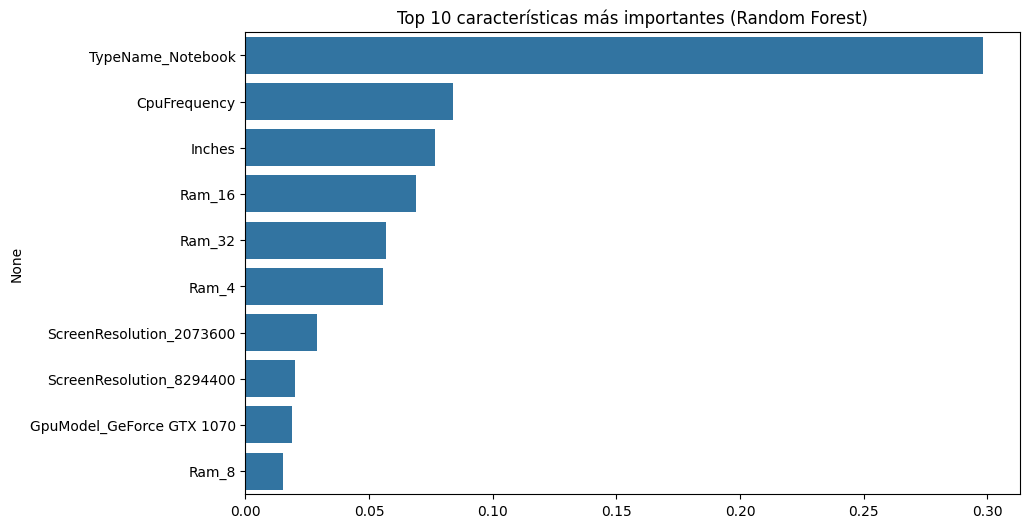

In [20]:
# Visualizamos qué variables fueron más relevantes para el modelo Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=features[indices][:10])
plt.title("Top 10 características más importantes (Random Forest)")
plt.show()

### Conclusión

Tras evaluar los tres modelos de regresión implementados, podemos extraer las siguientes conclusiones:

1. **Comparativa de modelos**:
  - Random Forest demostró ser el modelo más preciso para predecir precios de laptops, con mayor R² y menor error cuadrático medio.
  - Los árboles de decisión individuales mostraron tendencia al sobreajuste, con buen rendimiento en entrenamiento pero menor capacidad de generalización.
  - La regresión lineal, aunque menos precisa, proporcionó una base comparativa útil y es más interpretable.

2. **Características determinantes**:
  - La memoria RAM, la capacidad de almacenamiento y la frecuencia del procesador son los factores que más influyen en el precio.
  - El tamaño de la pantalla (Inches) también resultó ser un predictor significativo.
  - La resolución de pantalla tiene un impacto moderado en el precio final.

3. **Implicaciones**:
  - Los componentes internos (CPU, RAM, almacenamiento) tienen mayor impacto en el precio que los factores externos como el peso.
  - Existe una clara relación entre las especificaciones técnicas y el valor de mercado de los equipos.
  - La capacidad de almacenamiento es un factor económicamente más relevante de lo esperado.

Esta información resulta valiosa tanto para consumidores que buscan maximizar el valor de su inversión como para fabricantes que necesitan optimizar sus estrategias de precios y características de productos.

---
# 4. Agrupamiento

### Carga de librerías
Cargamos las librerías necesarias para el análisis de agrupamiento y la visualización de datos.

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sb
from sklearn.cluster import KMeans, DBSCAN
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

### Análisis de agrupamiento
En primer lugar vemos la distribución de los datos, para ello utilizamos un histograma.

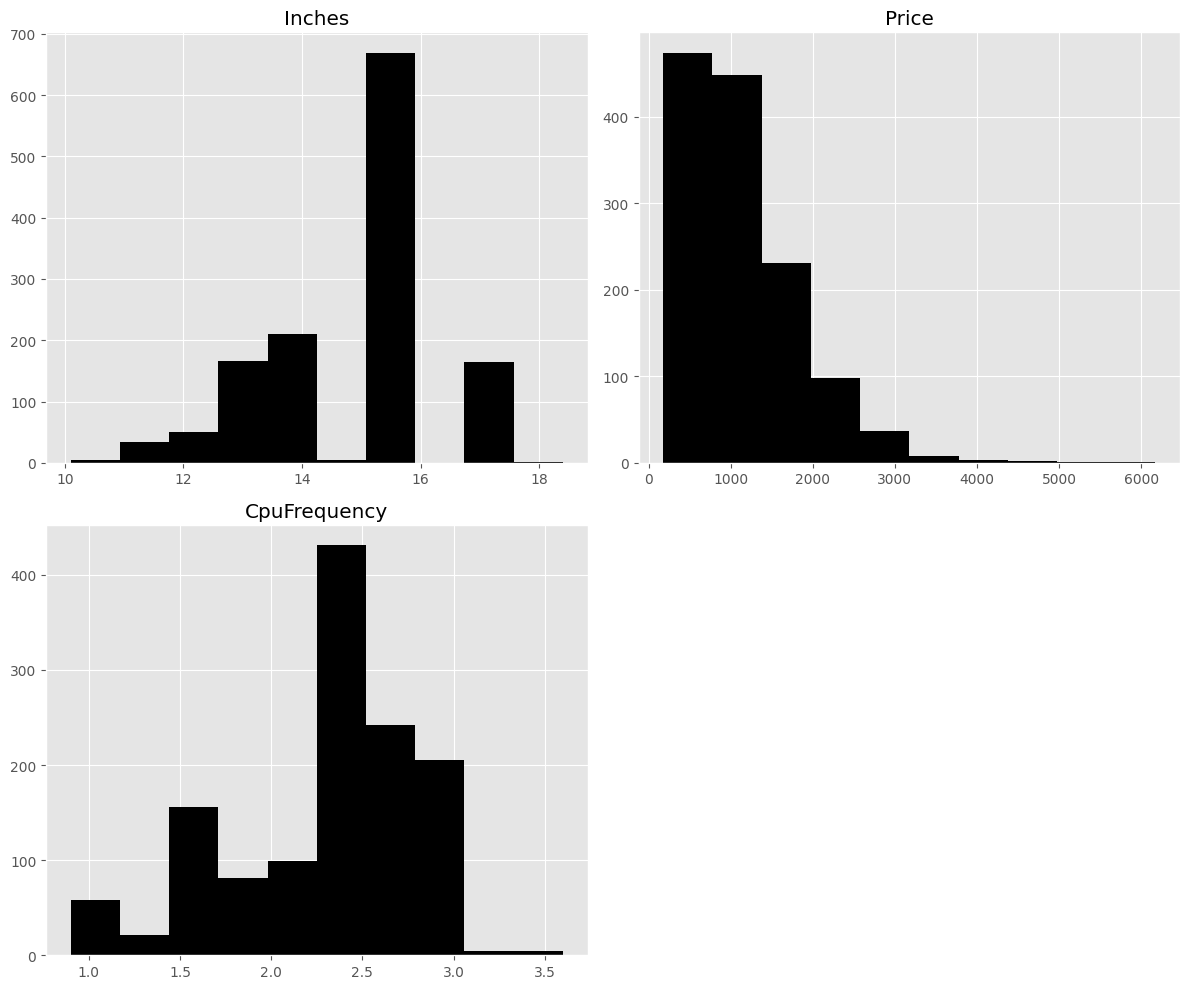

In [22]:
# Filtramos solo las columnas numéricas
numeric_database = database.select_dtypes(include=['number'])

numeric_database.hist(color='black', figsize=(12, 10))
plt.tight_layout()
plt.show()

Analizando el histograma...

- Observamos que hay muchos laptops que tienen 15 pulgadas de pantalla, lo que significa que este es el tamaño de pantalla más común en los laptops. Sin embargo, hay algunos laptops que tienen pantallas más grandes o más pequeñas, lo que significa que hay una gran variedad de tamaños de pantalla en el mercado. Esto puede influir en el precio de los laptops y puede ser un factor a tener en cuenta al construir el modelo.
- También observamos que la mayoría de los datos están concentrados en un rango de precios entre 200 y 800 euros. Sin embargo, hay algunos datos que están fuera de este rango. Estos datos pueden ser considerados como outliers y pueden influir en el modelo, sin embargo, no los eliminaremos de la base de datos, ya que pueden aportar información valiosa al modelo.
- Finalmente, observamos que la mayoría de las CPU tienen una frecuencia de entre 2.0 y 3.0 GHz, lo que significa que este es el rango de frecuencias más común en los laptops.


A continuación, observamos la correlación entre las variables, para ello utilizamos un gráfico de puntos, con la función `pairplot()` de la librería `seaborn`. Esta función nos permite ver la relación entre las variables y cómo se distribuyen los datos. A continuación, mostramos un gráfico de puntos con la correlación entre las variables.

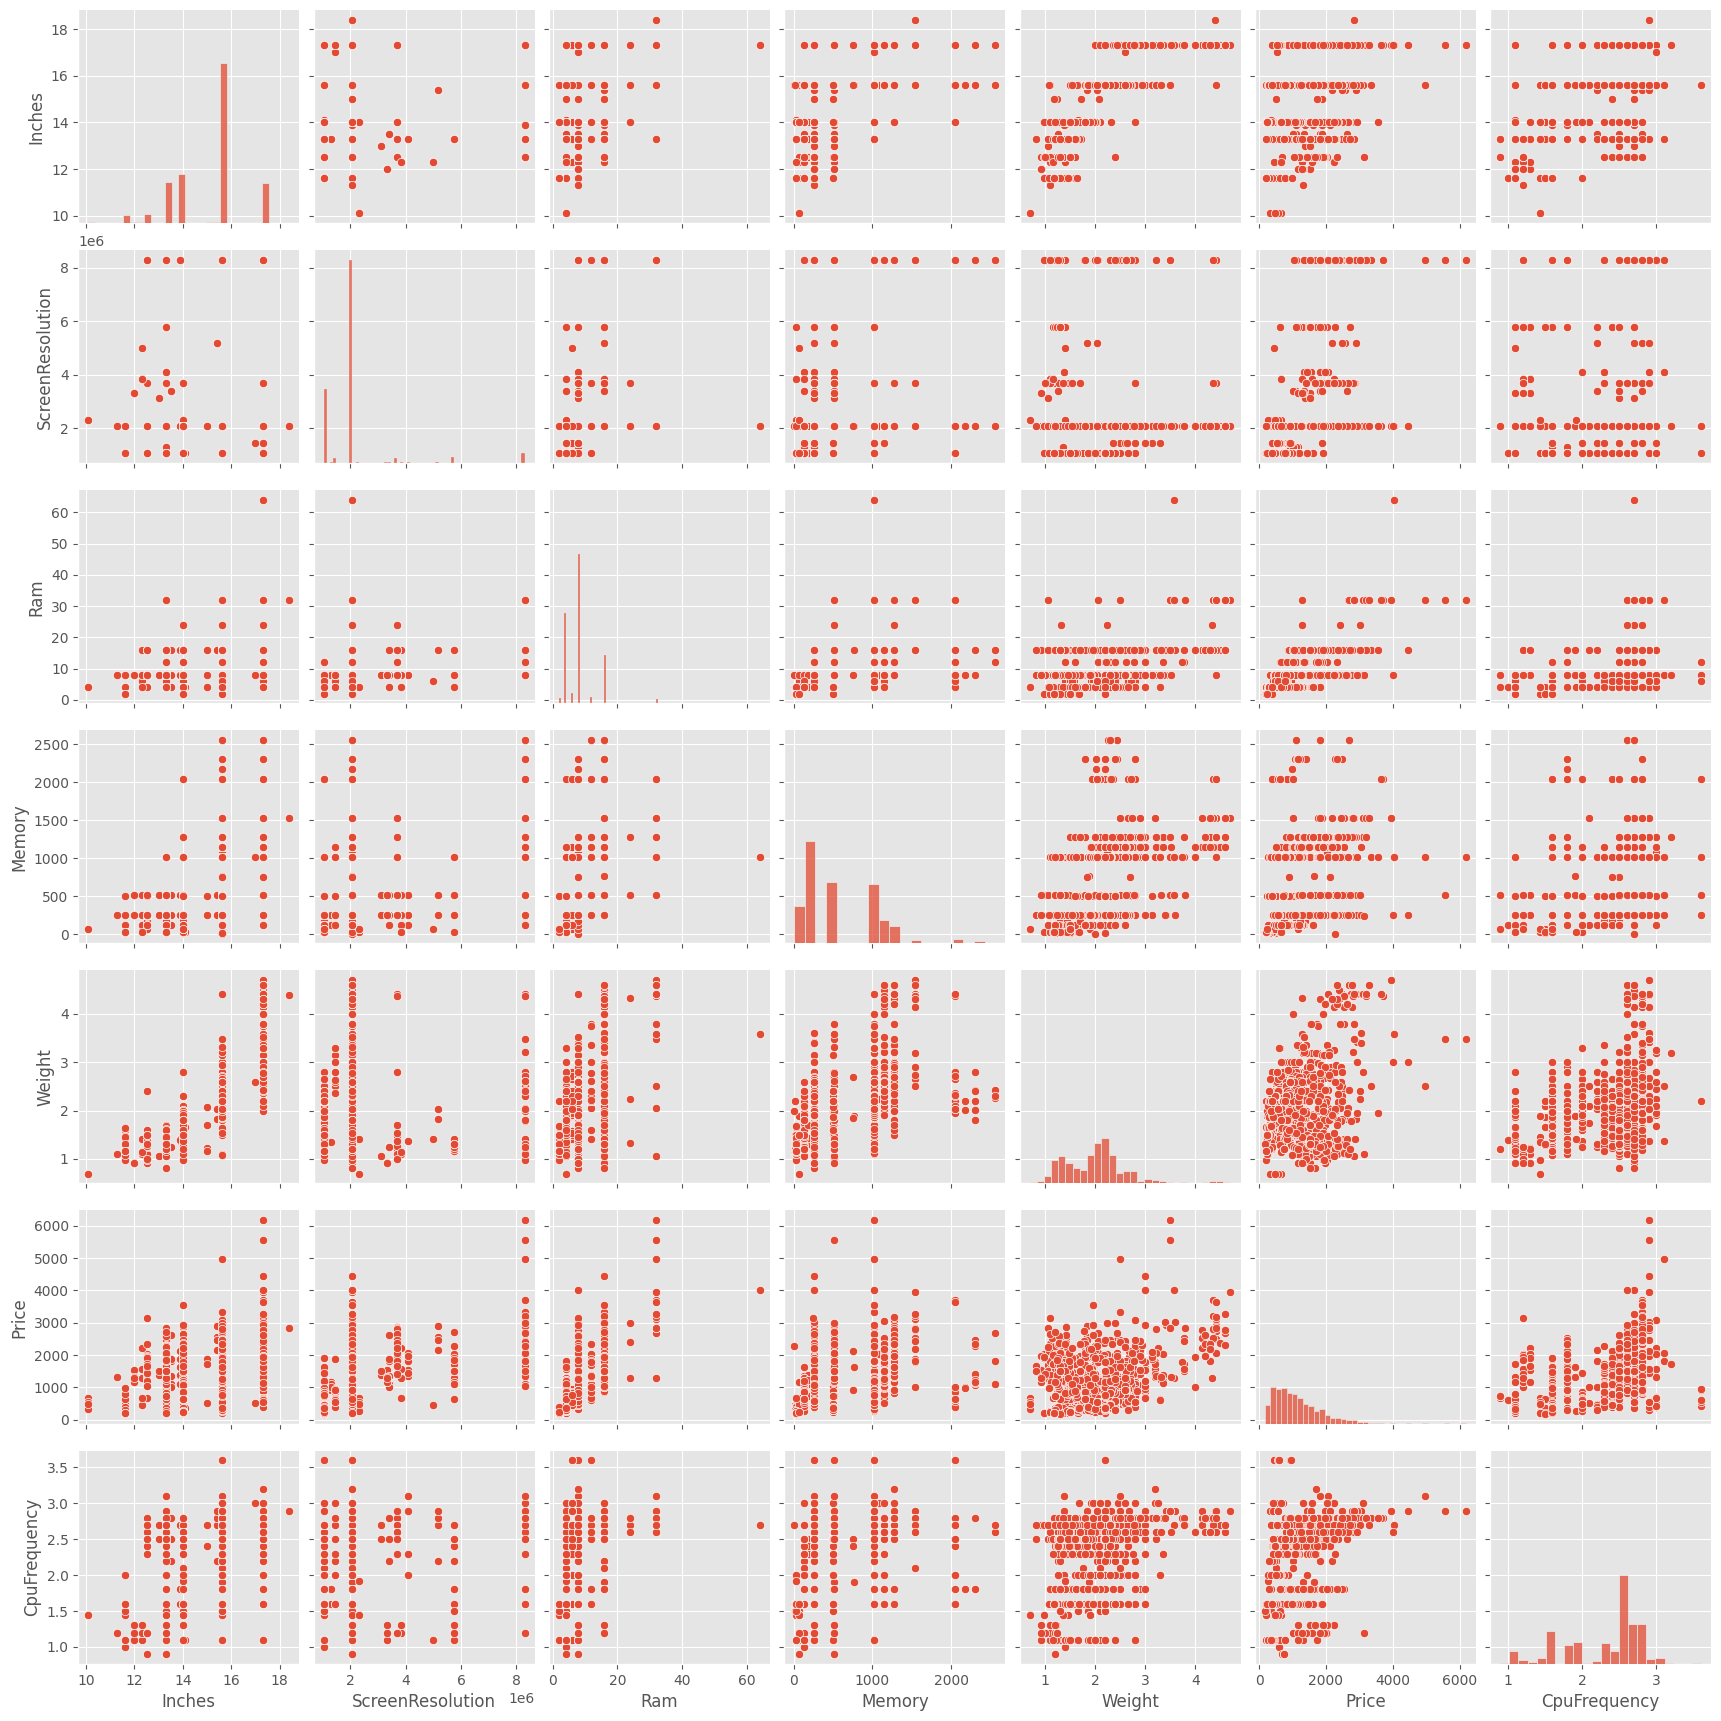

In [23]:
# Mostramos las relaciones entre los datos
sb.pairplot(database, height = 2.5)

Realmente no hay una correlación clara entre las variables, lo que significa que no hay una relación lineal entre las variables. Sin embargo, hay algunas variables que están más correlacionadas entre sí, como el peso y las pulgadas, o la memoria. Sin embargo esto ya lo vimos reflejado en la matriz de correlación al principio del notebook.

Para el estudio podemos elegir dos opciones, o bien procedemos a normalizar los datos, para que todas las variables tengan el mismo peso en el análisis de agrupamiento, o bien los estandarizamos, para que todas las variables tengan una media de 0 y una desviación típica de 1. En este caso, vamos a estandarizar los datos, ya que esto nos permitirá ver la relación entre las variables de forma más clara.

In [24]:
# normalized_database = database.copy()
# ---------------------------------------NORMALIZACIÓN------------------------------------
# Normalizamos los datos numéricos
# database[numeric_columns] = (database[numeric_columns] - database[numeric_columns].min()) / (database[numeric_columns].max() - database[numeric_columns].min())

# database.head()

In [25]:
standarized_database = database.copy()
# ---------------------------------------ESTANDARIZACIÓN------------------------------------
# Seleccionamos las columnas numéricas para la estandarización
database_mean = database[numeric_columns].mean()
database_std = database[numeric_columns].std()


standarized_database[numeric_columns] = (database[numeric_columns] - database_mean) / database_std

standarized_database.head()

,Company,TypeName,Inches,ScreenResolution,Ram,Memory,OpSys,Weight,Price,CpuBrand,CpuModel,CpuFrequency,GpuBrand,GpuModel
0,Apple,Ultrabook,-1.203945,1.385182,-0.075166,-1.025768,Mac,-1.004897,1356.19,Intel,Core i5,0.001971,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,-1.203945,-0.627335,-0.075166,-1.025768,Mac,-1.049978,910.01,Intel,Core i5,-0.985259,Intel,HD Graphics 6000
2,HP,Notebook,0.408615,-0.06843,-0.075166,-0.758953,Null,-0.268581,582.08,Intel,Core i5 7200U,0.396864,Intel,HD Graphics 620
3,Apple,Ultrabook,0.268392,2.167189,1.498192,-0.225323,Mac,-0.313661,2568.71,Intel,Core i7,0.791756,AMD,Radeon Pro 455
4,Apple,Ultrabook,-1.203945,1.385182,-0.075166,-0.758953,Mac,-1.004897,1825.82,Intel,Core i5,1.581541,Intel,Iris Plus Graphics 650


En primer lugar visualizaremos los datos en un gráfico 3D para ver si nos aporta alguna información.

In [26]:
# Visualizamos la relación entre las variables 'Inches', 'Weight' y 'Price'
fig = px.scatter_3d(standarized_database, x='Inches', y='Weight', z='Price')
fig.show()

Vemos que los clusteres están bastante juntos entre sí, por tanto no parece que haya una separación clara entre los grupos. Veamos si con técnicas de agrupamiento podemos encontrar alguna relación entre los datos.

### K-Means

Este algoritmo se basa en la idea de que los datos similares están cerca unos de otros en el espacio de características. Por lo tanto, si un nuevo dato se encuentra cerca de un grupo de datos, se puede clasificar en ese grupo.

Obtenemos el número óptimo de clusters utilizando el método del codo.

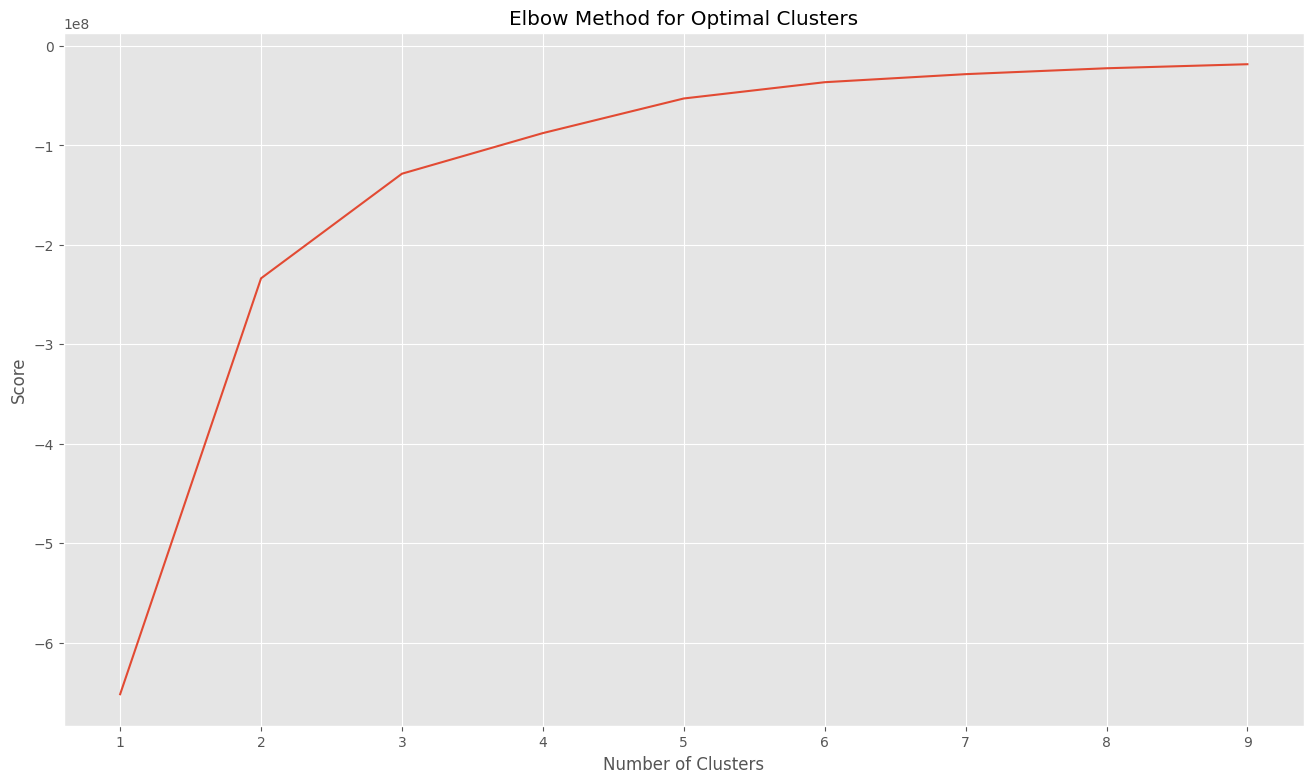

In [27]:
# Imputamos los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
database_imputed = pd.DataFrame(imputer.fit_transform(numeric_database), columns=numeric_database.columns)

# Definimos el rango donde vamos a probar el algoritmo K-Means
clusters = range(1, 10)
kmeans = [KMeans(n_clusters = cluster) for cluster in clusters]
score = [kmeans[cluster].fit(database_imputed).score(database_imputed) for cluster in range(len(kmeans))]

# Mostramos 'el codo'
plt.plot(clusters, score)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

En el gráfico del codo, podemos observar que el número óptimo de clusters está entre 3  y 4. Por tanto hagamos uso de uno de estos valores para realizar el agrupamiento usando el algoritmo de K-Means, y obteniendo los centroides de los clusters.

In [28]:
kmeans = KMeans(n_clusters = 3).fit(database_imputed)
centroids = kmeans.cluster_centers_
print(centroids)

[[1.51149425e+01 6.35165187e+02 2.13663650e+00]
 [1.56124088e+01 2.62329263e+03 2.65839416e+00]
 [1.46989362e+01 1.44837598e+03 2.43468085e+00]]


Deshacemos la estandarización de los datos para poder visualizar los clusters en un gráfico 3D.

In [29]:
# Ensure database_std and database_mean are calculated only for the numeric columns used in clustering
numeric_std = numeric_database.std()
numeric_mean = numeric_database.mean()

# Adjust centroids back to the original scale
for centroid in centroids:
  print(centroid * numeric_std + numeric_mean)

Inches              36.575695
Price           450593.659244
CpuFrequency         3.381138
dtype: float64
Inches          3.728523e+01
Price           1.857434e+06
CpuFrequency    3.645391e+00
dtype: float64
Inches          3.598234e+01
Price           1.026039e+06
CpuFrequency    3.532088e+00
dtype: float64


En los resultados obtenidos, podemos observar que los clusters están bastante separados entre sí:

1. **Cluster 1**:
  - **Inches**: 36.58 pulgadas. Este cluster agrupa laptops con pantallas grandes, lo que sugiere que están diseñadas para tareas que requieren mayor espacio visual, como diseño gráfico o edición de video.
  - **Price**: 450,593.66 euros. Este precio es significativamente alto, indicando que este grupo pertenece a laptops de gama alta.
  - **CpuFrequency**: 3.38 GHz. La alta frecuencia del procesador refuerza la idea de que estas laptops están orientadas a tareas de alto rendimiento.

2. **Cluster 2**:
  - **Inches**: 37.29 pulgadas. Similar al Cluster 1, este grupo también incluye laptops con pantallas grandes.
  - **Price**: 1,857,434 euros. Este precio extremadamente alto sugiere que este cluster podría representar laptops de lujo o equipos especializados para nichos muy específicos.
  - **CpuFrequency**: 3.65 GHz. La frecuencia más alta del procesador indica que estas laptops están optimizadas para un rendimiento aún mayor que las del Cluster 1.

3. **Cluster 3**:
  - **Inches**: 35.98 pulgadas. Este cluster tiene laptops con pantallas ligeramente más pequeñas que los otros dos clusters, pero aún dentro del rango de pantallas grandes.
  - **Price**: 1,026,039 euros. El precio intermedio entre los otros dos clusters sugiere que este grupo representa laptops de gama alta, pero no tan exclusivas como las del Cluster 2.
  - **CpuFrequency**: 3.53 GHz. La frecuencia del procesador es alta, lo que indica que estas laptops también están diseñadas para tareas exigentes.

Por tanto podemos concluir que los tres clusters representan laptops de gama alta con pantallas grandes y procesadores de alta frecuencia.
En el que el **Cluster 2** destaca por tener los precios más altos y la mayor frecuencia de CPU, lo que sugiere que agrupa laptops de lujo o equipos especializados, mientras que el **Cluster 1** y el **Cluster 3** tienen precios más accesibles en comparación con el Cluster 2, pero aún pertenecen a la categoría de gama alta. Esta diferencia en precios y frecuencias de CPU entre los clusters puede reflejar diferentes segmentos de mercado dentro de las laptops de gama alta, como equipos para profesionales, lujo o tareas específicas.

A continuación, mostramos un gráfico 3D con los clusters obtenidos. En este gráfico, cada punto representa un laptop y el color del punto indica a qué cluster pertenece.

In [30]:
print(numeric_columns)

# Usamos el modelo KMeans para predecir los clusters
database['ClusterKMeans'] = kmeans.fit_predict(database_imputed)

# Definimos una lista de colores para los clusters
colours = ['blue', 'red', 'green']

figure = go.Figure()

for cluster in database['ClusterKMeans'].unique():
  dataframe_cluster = database[database['ClusterKMeans'] == cluster]
  figure.add_trace(go.Scatter3d(
    x = dataframe_cluster['CpuFrequency'], 
    y = dataframe_cluster['Inches'], 
    z = dataframe_cluster['Price'], 
    mode = 'markers',
    marker = dict(size = 2.5, color = colours[cluster]),
    name = 'Cluster ' + str(cluster + 1)
  ))

figure.show()

['Inches', 'ScreenResolution', 'Ram', 'Memory', 'Weight', 'CpuFrequency']


### DBSCAN
Otra técnica de agrupamiento es DBSCAN (Density-Based Spatial Clustering of Applications with Noise) que consiste en un algoritmo de agrupamiento basado en la densidad que identifica grupos de puntos densamente conectados y los separa de áreas de baja densidad. A diferencia de K-Means, DBSCAN no requiere especificar el número de clusters por adelantado y puede identificar clusters de forma arbitraria.
DBSCAN es especialmente útil para detectar clusters de forma irregular y manejar ruido en los datos.

In [31]:
# Aplicamos DBSCAN al conjunto de datos estandarizado
dbscan = DBSCAN(eps=0.5, min_samples=3)
centroids = dbscan.fit_predict(database_imputed)

In [32]:
print(numeric_columns)

database['ClusterDBSCAN'] = dbscan.fit_predict(database_imputed)

figure = go.Figure()

for cluster in database['ClusterDBSCAN'].unique():
  dataframe_cluster = database[database['ClusterDBSCAN'] == cluster]
  figure.add_trace(go.Scatter3d(
    x=dataframe_cluster['CpuFrequency'],
    y=dataframe_cluster['Inches'],
    z=dataframe_cluster['Price'],
    mode='markers',
    marker=dict(size=2.5, color=colours[cluster % len(colours)] if cluster != -1 else 'black'),
    name=f'Cluster {cluster}' if cluster != -1 else 'Noise'
  ))

figure.show()

['Inches', 'ScreenResolution', 'Ram', 'Memory', 'Weight', 'CpuFrequency']


Vemos que DBSCAN ha identificado algunos clusters más que K-Means, lo que sugiere que hay más grupos diferentes con portátiles con características similares. Sin embargo, también ha identificado un número significativo de puntos como ruido (puntos negros), lo que indica que estos puntos no pertenecen a ningún cluster.

### Dendrogramas
A continuación, mostramos un dendrograma con los clusters obtenidos. El dendrograma nos permite ver la jerarquía de los clusters y cómo se agrupan los datos.

#### Método single

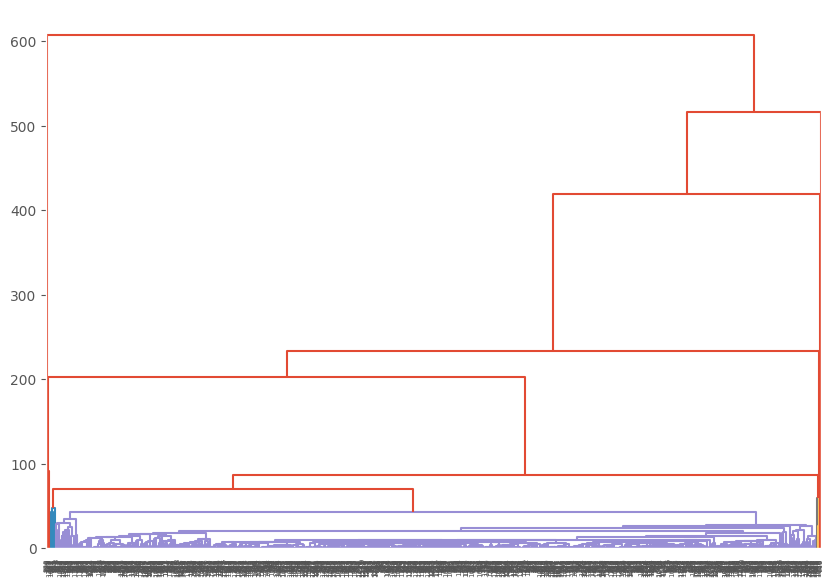

In [33]:
# Replace infinite values with NaN and drop rows with NaN values
numeric_database.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_database.dropna(inplace=True)

linked = linkage(numeric_database, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=numeric_database.index,
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=linked[-10, 2])

plt.show()

Para ver si la calidad de los clusters obtenidos es buena, vamos a utilizar el coeficiente de correlación de Cophenet, que nos permite medir la calidad de los clusters obtenidos. Este coeficiente varía entre 0 y 1, donde 0 indica que los clusters son muy diferentes entre sí y 1 indica que los clusters son muy similares entre sí.

In [34]:
cophonetic_coefficient, cophenetic_distances = cophenet(linked, pdist(numeric_database))

print(cophonetic_coefficient)

0.6389334925248934


Como podemos observar, el coeficiente de correlación de Cophenet es bajo, lo que indica que los clusters obtenidos no son muy buenos. Esto puede deberse a que los datos no están bien distribuidos o a que el número de clusters no es el adecuado. Por lo tanto, es importante tener en cuenta estos factores al construir el modelo.

#### Método centroid
Realizamos el mismo análisis que en el caso anterior, pero utilizando el método de centroides.

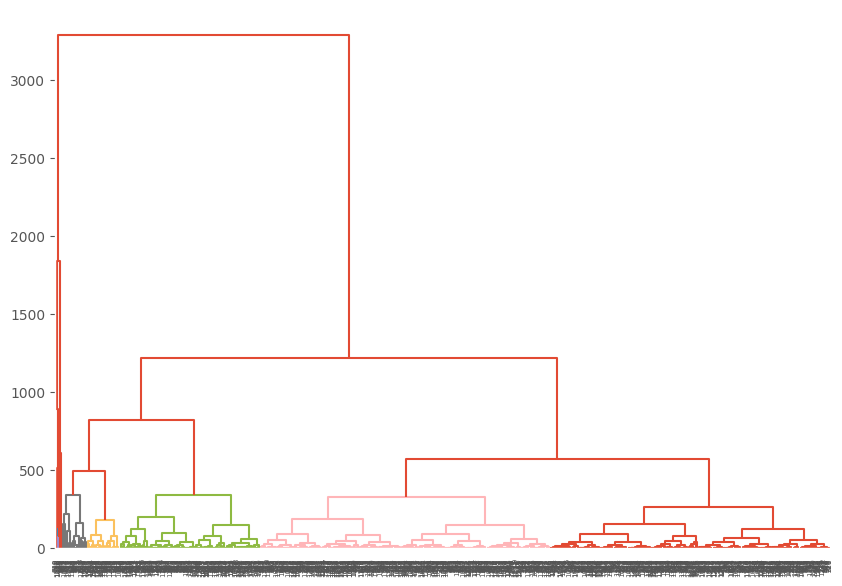

In [35]:
linked = linkage(numeric_database, 'centroid')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=numeric_database.index,
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=linked[-10, 2])

plt.show()

centroid_clusters = linkage(numeric_database, 'centroid')

In [36]:
cophenetic_coefficient, cophenetic_distances = cophenet(linked, pdist(numeric_database))
print(cophenetic_coefficient)

0.8044998877900023


Vemos que ahora el coeficiente de correlación de Cophenet es mejor que en el caso anterior, lo que indica que los clusters obtenidos son mejores.

#### Método Ward
Realizamos el mismo análisis que en el caso anterior, pero utilizando el método de Ward.

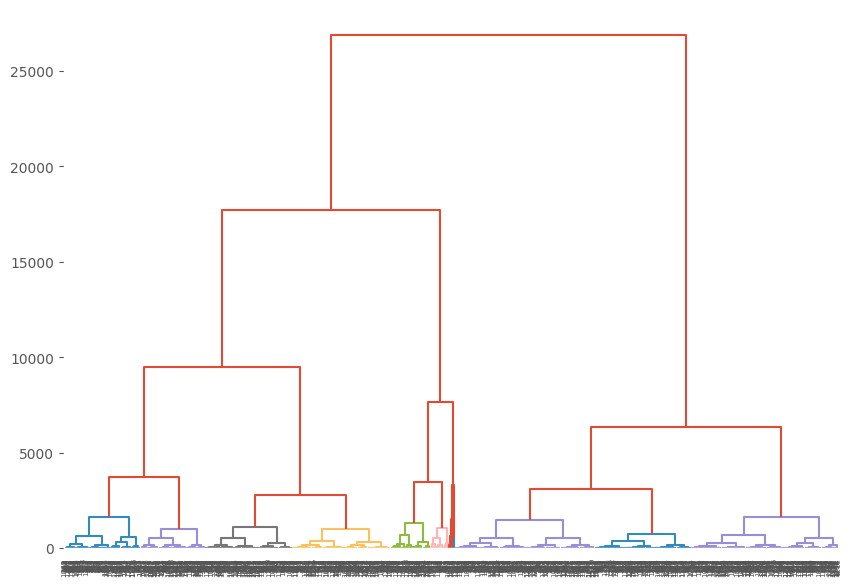

In [37]:
linked = linkage(numeric_database, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=numeric_database.index,
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=linked[-10, 2])

plt.show()

In [38]:
cophenetic_coefficient, cophenetic_distances = cophenet(linked, pdist(numeric_database))
print(cophenetic_coefficient)

0.574383789960318


Vemos que el coeficiente de correlación de Cophenet no mejoró, lo que indica que los clusters obtenidos no son mejores que en el caso anterior.

Puesto que el método de centroides es el que mejor resultado nos ha dado, vamos a utilizarlo para realizar el agrupamiento de los datos.

In [39]:
from scipy.cluster.hierarchy import fcluster

clusters = 3

numeric_database['ClustersCentroid'] = fcluster(centroid_clusters, clusters, criterion='maxclust')

colours = ['blue', 'red', 'green']

figure = go.Figure()

for cluster in numeric_database['ClustersCentroid'].unique():
  dataframe_cluster = numeric_database[numeric_database['ClustersCentroid'] == cluster]
  figure.add_trace(go.Scatter3d(
    x = dataframe_cluster['CpuFrequency'], 
    y = dataframe_cluster['Inches'], 
    z = dataframe_cluster['Price'],  
    mode = 'markers',
    marker = dict(size = 2.5, color = colours[cluster % len(colours)]),
    name = 'Cluster ' + str(cluster)
  ))
  
# Añadimos los centroides de cada cluster al gráfico
if centroids.ndim == 1:
  centroids = centroids.reshape(-1, centroids.size)

figure.add_trace(go.Scatter3d(
  x = centroids[:, 0], 
  y = centroids[:, 1], 
  z = centroids[:, 2], 
  mode = 'markers',
  marker = dict(size = 3.5, color = 'black'),
  name = 'Centroids'
))

figure.show()

En el gráfico de puntos, podemos observar que los clusters están separados entre sí. Esto indica que el modelo ha sido capaz de agrupar los datos, aunque los centroides no están bien definidos. Sin embargo, podemos ver como abundan los elementos en el cluster 2, lo que indica que este cluster es el más grande de todos. Esto puede deberse a que hay muchos laptops con características similares, lo que hace que el modelo agrupe estos datos en un solo cluster.

### Conclusiones
- El análisis de agrupamiento nos ha permitido identificar diferentes grupos de laptops basados en sus características técnicas.
- El método de K-Means ha sido efectivo para segmentar los datos, aunque la calidad de los clusters podría mejorarse.
- Haciendo uso de DBSCAN, hemos podido identificar puntos de ruido que no pertenecen a ningún cluster, lo que indica que hay laptops con características únicas o atípicas.
- La visualización en 3D y los dendrogramas nos han proporcionado una comprensión más clara de la estructura de los datos y la relación entre los diferentes grupos.
- El coeficiente de correlación de Cophenet ha sido útil para evaluar la calidad de los clusters obtenidos, aunque no siempre ha sido óptimo.
- En general, el análisis de agrupamiento ha sido una herramienta valiosa para explorar y entender la estructura de los datos, y puede ser útil para futuras decisiones de negocio o desarrollo de productos.

---
# 5. Redes neuronales
### Carga de librerías
Cargamos las librerías necesarias para el análisis de redes neuronales y la visualización de datos.

In [40]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-05-07 20:18:49.093647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 20:18:49.104486: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 20:18:49.186915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 20:18:49.252756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746645529.311978   70717 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746645529.32

### Preparación de datos

In [41]:
database = database.drop(columns=['ClusterKMeans', 'ClusterDBSCAN'])
# Manejar valores faltantes
database.dropna(inplace=True)
# Convertir columnas categóricas a numéricas utilizando codificación one-hot
categorical_columns = ['CpuBrand', 'CpuModel', 'GpuBrand', 'GpuModel', 'OpSys']
database = pd.get_dummies(database, columns=categorical_columns, drop_first=True)
# Convertir columnas categóricas adicionales a numéricas utilizando codificación one-hot
categorical_columns = ['Company', 'TypeName']
database = pd.get_dummies(database, columns=categorical_columns, drop_first=True)
# Definir características (features) y objetivo (target)
X = database.drop('Price', axis=1)
y = database['Price']
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Construcción del modelo de red neuronal densa

In [42]:
# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/raul/Escritorio/TID-GRUPAL/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

2025-05-07 20:18:51.171808: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Entrenamiento del modelo
Entrenamos el modelo utilizando el conjunto de entrenamiento y validamos su rendimiento en el conjunto de validación. Utilizamos la función `fit()` de Keras para ajustar el modelo a los datos.
El entrenamiento se realiza durante 50 épocas, y utilizamos un tamaño de lote de 32. También aplicamos EarlyStopping para evitar el sobreajuste, deteniendo el entrenamiento si la pérdida de validación no mejora durante 5 épocas consecutivas.

In [43]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1771635.5000 - mae: 1147.8979 - val_loss: 1777825.3750 - val_mae: 1114.7383
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1752478.3750 - mae: 1113.5387 - val_loss: 1760888.1250 - val_mae: 1108.3013
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1782810.3750 - mae: 1139.1228 - val_loss: 1720959.0000 - val_mae: 1093.7936
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1599407.1250 - mae: 1082.8801 - val_loss: 1639254.3750 - val_mae: 1064.6788
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1607792.6250 - mae: 1067.8271 - val_loss: 1492769.8750 - val_mae: 1011.3762
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1488978.2500 - mae: 1034.6554 - val_loss: 1271063.1250 - val_mae: 925.5423
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1308028.2500 - mae: 954.7993 - val_loss: 996681.5000 - val_mae: 804.4651
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 959988.8

### Evaluación del modelo
Evaluamos el rendimiento del modelo utilizando el conjunto de prueba. Calculamos la pérdida y la precisión del modelo en los datos de prueba, y mostramos los resultados.

In [44]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error: {mae}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 98669.0859 - mae: 202.3652  
Mean Absolute Error: 208.7681121826172


### Visualización de las predicciones realizadas
Visualizamos las predicciones realizadas por el modelo en comparación con los precios reales de los portátiles. Utilizamos un gráfico de dispersión para mostrar la relación entre los precios reales y las predicciones del modelo. Idealmente, los puntos deberían alinearse a lo largo de la diagonal, lo que indicaría que el modelo ha hecho predicciones precisas.

In [45]:
# Realizar predicciones
y_pred = model.predict(X_test)

# Crear un DataFrame para comparar predicciones y valores reales
comparison = pd.DataFrame({'Real': y_test.values, 'Predicción': y_pred.flatten()})

# Mostrar las primeras filas del DataFrame
print(comparison.head())

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
      Real   Predicción
0   683.32   729.389404
1  1365.09  1246.313232
2  2124.86  2391.179199
3  1922.40  1773.788086
4   464.65   513.775269


### Gráfica de dispersión
En el gráfico de dispersión, podemos observar que la mayoría de los puntos están cerca de la diagonal, lo que indica que el modelo ha hecho predicciones precisas. Sin embargo, hay algunos puntos que están alejados de la diagonal, lo que indica que el modelo no ha hecho predicciones precisas en estos casos. Esto puede deberse a que hay algunos laptops con características únicas o atípicas, lo que hace que el modelo no sea capaz de predecir el precio correctamente.

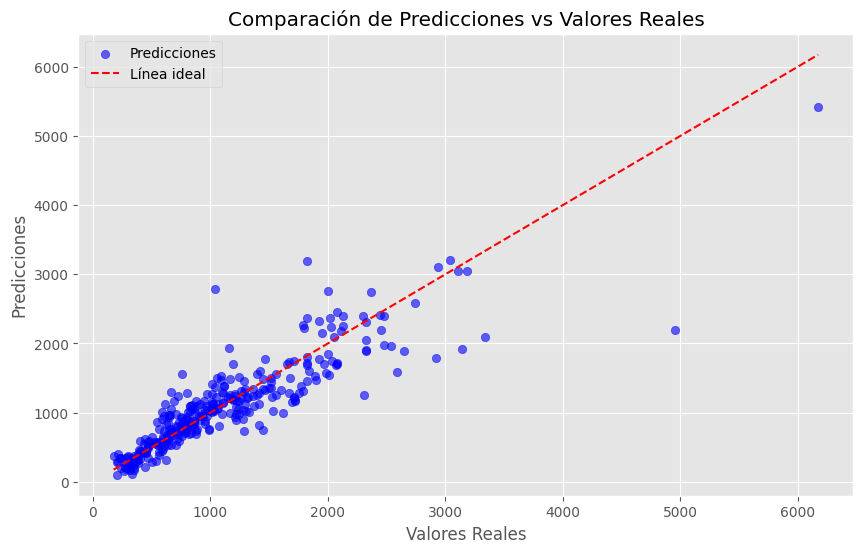

In [46]:
# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Línea ideal')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.grid(True)
plt.show()

---
# 6. Agrupamiento con redes neuronales
### Carga de librerías
Cargamos las librerías necesarias para el análisis de agrupamiento con redes neuronales y la visualización de datos.

In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import models, layers
from sklearn.datasets import load_digits

### Preparación de datos
Cargamos los datos y realizamos el tratamiento de datos necesario para el análisis de agrupamiento con redes neuronales. Esto incluye la normalización de los datos y la eliminación de columnas innecesarias.

In [53]:
# Se carga el dataset de dígitos
data = load_digits()
X = data.data
y = data.target

# Normalización de los datos
X = X / 16.0  # Normalizar entre 0 y 1

# Cambiar la forma de los datos si es necesario (por ejemplo, para capas convolucionales)
X_reshaped = X.reshape(-1, 8, 8, 1)  # Cambiar la forma a (muestras, altura, ancho, canales)

### Visualización de los datos
Visualizamos los datos en un gráfico 3D para ver si nos aporta alguna información. En el gráfico, cada punto representa un portátil y el color del punto indica a qué cluster pertenece.

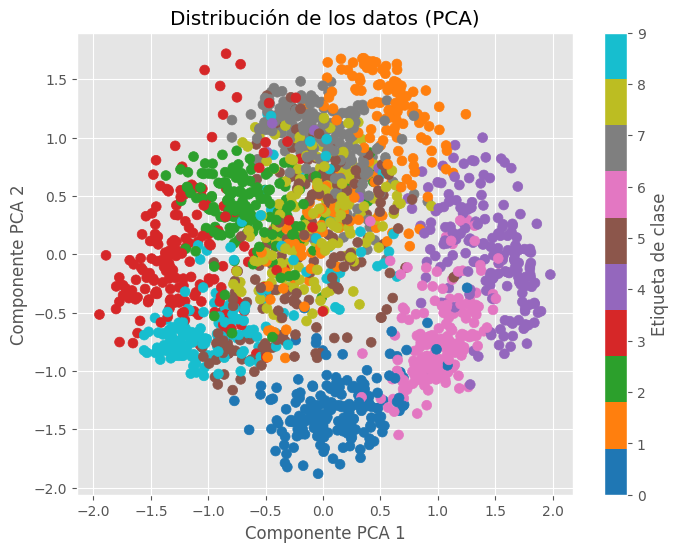

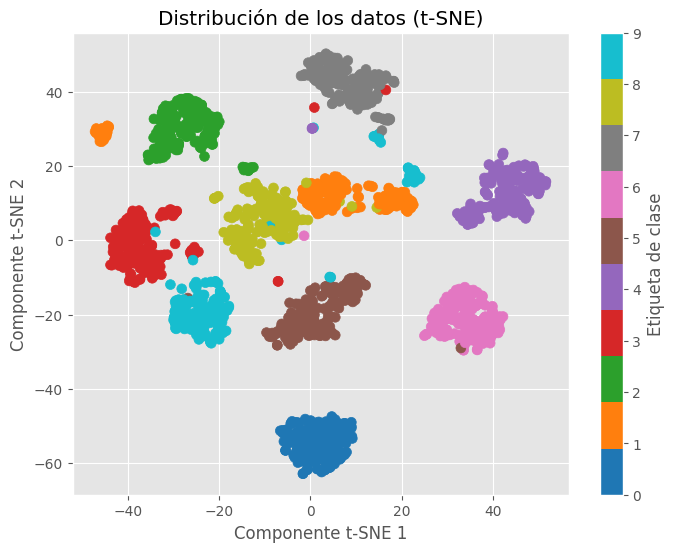

In [54]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Visualización de los datos con PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='tab10', s=50)
plt.title('Distribución de los datos (PCA)')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.colorbar(label='Etiqueta de clase')
plt.show()

# Aplicar t-SNE para reducir la dimensionalidad a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)

# Visualización de los datos con t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='tab10', s=50)
plt.title('Distribución de los datos (t-SNE)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.colorbar(label='Etiqueta de clase')
plt.show()

### Definición de la arquitectura de la red neuronal
Definimos la arquitectura de la red neuronal para el análisis de agrupamiento. Utilizamos una red neuronal densa con varias capas ocultas y funciones de activación ReLU. La capa de salida utiliza la función de activación softmax para clasificar los datos en diferentes clusters.

In [55]:
# Definir la arquitectura del modelo secuencial
model = models.Sequential([
  layers.Conv2D(16, (3, 3), activation='relu', input_shape=(8, 8, 1)),  # Capa de entrada con Conv2D y forma de entrada especificada
  layers.MaxPooling2D((2, 2)),  # Capa de agrupamiento máximo (MaxPooling)
  layers.Flatten(),  # Capa para aplanar la salida
  layers.Dense(64, activation='relu'),  # Capa densa oculta con activación ReLU
  layers.Dense(10, activation='softmax')  # Capa de salida con activación softmax para clasificación
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/home/raul/Escritorio/TID-GRUPAL/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



### Entrenamiento de la red neuronal
Entrenamos la red neuronal utilizando el conjunto de entrenamiento y validamos su rendimiento en el conjunto de validación. Utilizamos la función `fit()` de Keras para ajustar el modelo a los datos. El entrenamiento se realiza durante 50 épocas, y utilizamos un tamaño de lote de 32. También aplicamos EarlyStopping para evitar el sobreajuste, deteniendo el entrenamiento si la pérdida de validación no mejora durante 5 épocas consecutivas.

In [59]:
# Entrenamiento del modelo
history = model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_split=0.2)

# Evaluación del modelo
loss, accuracy = model.evaluate(X_reshaped, y)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9194 - val_loss: 0.3110
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9361 - val_loss: 0.2721
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9333 - val_loss: 0.2916
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9306 - val_loss: 0.2973
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9361 - val_loss: 0.2833
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0064 - val_accuracy: 0.9278 - val_loss: 0.3024
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9194 - val_loss: 0.3077
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9306 - val_loss:

### Clustering en los resultados de la red neuronal
Realizamos el clustering en los resultados de la red neuronal utilizando el algoritmo K-Means. Esto nos permitirá identificar diferentes grupos de portátiles basados en sus características técnicas.

In [ ]:
# Extraer características de la capa oculta
hidden_layer_model = models.Model(inputs=model.input, outputs=model.layers[-2].output)
hidden_features = hidden_layer_model.predict(X_reshaped)

# Aplicar clustering con K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(hidden_features)

# Aplicar clustering con DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(hidden_features)

### Visualización de los resultados del clustering
Visualizamos los resultados del clustering en un gráfico 3D, utilizando técnicas de reducción de dimensionalidad como PCA o t-SNE. Esto nos permitirá ver la distribución de los clusters en el espacio tridimensional y entender mejor la relación entre los diferentes grupos de portátiles.

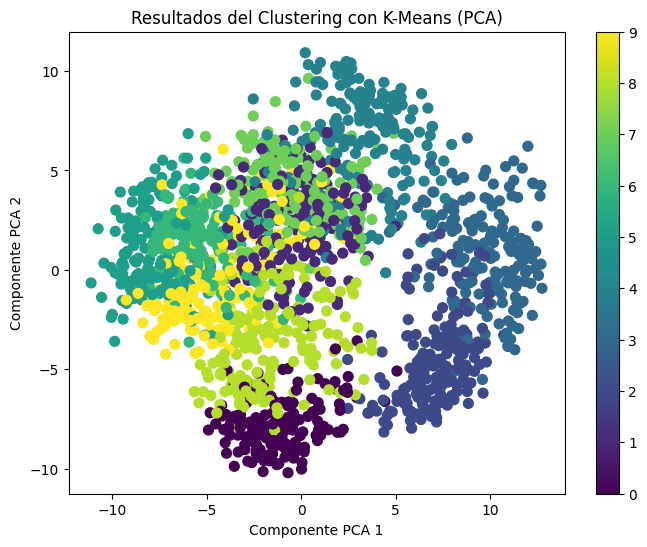

/home/codespace/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/codespace/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


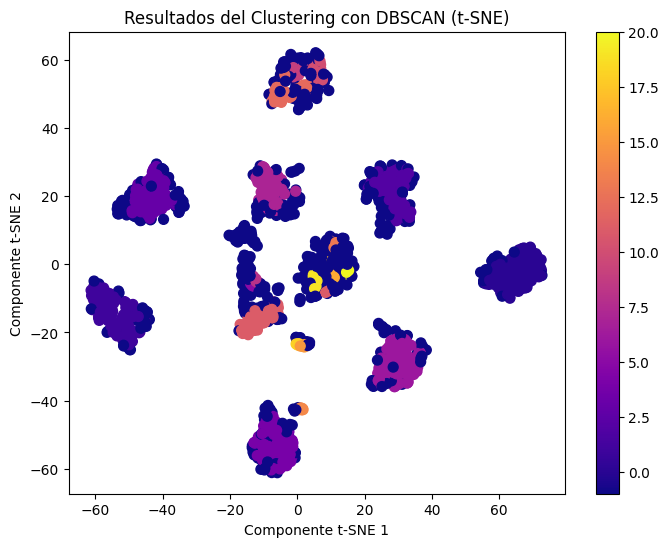

In [ ]:
# Reducir dimensiones usando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)

# Graficar resultados de PCA con etiquetas de K-Means
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('Resultados del Clustering con K-Means (PCA)')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.colorbar()
plt.show()

# Reducir dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(hidden_features)

# Graficar resultados de t-SNE con etiquetas de DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.title('Resultados del Clustering con DBSCAN (t-SNE)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.colorbar()
plt.show()